# Set up

In [1]:
!pip install tensorflow==2.10 tensorflow_gpu==2.10 opencv-python matplotlib scikit-learn

You should consider upgrading via the 'E:\TFlow\venv_tf_gpu\Scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
!pip list

Package                      Version
---------------------------- -----------
absl-py                      2.1.0
asttokens                    2.4.1
astunparse                   1.6.3
cachetools                   5.3.3
certifi                      2024.2.2
charset-normalizer           3.3.2
colorama                     0.4.6
comm                         0.2.2
contourpy                    1.2.1
cycler                       0.12.1
debugpy                      1.8.1
decorator                    5.1.1
exceptiongroup               1.2.1
executing                    2.0.1
flatbuffers                  24.3.25
fonttools                    4.51.0
gast                         0.4.0
google-auth                  2.29.0
google-auth-oauthlib         0.4.6
google-pasta                 0.2.0
grpcio                       1.63.0
h5py                         3.11.0
idna                         3.7
ipykernel                    6.29.4
ipython                      8.24.0
jedi                         0.19.1
j

You should consider upgrading via the 'E:\TFlow\venv_tf_gpu\Scripts\python.exe -m pip install --upgrade pip' command.


In [3]:
import tensorflow as tf
import os

In [4]:
gpus = tf.config.list_physical_devices('GPU')

# Delete invalid images

In [5]:
import cv2
import imghdr
import numpy as np
import shutil

In [6]:
original_data_dir = 'data'
new_data_dir = 'data_cleaned'

In [7]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [8]:
if not os.path.exists(new_data_dir):
    os.makedirs(new_data_dir)
    
for image_class in os.listdir(original_data_dir):
    new_class_dir = os.path.join(new_data_dir, image_class)
    os.makedirs(new_class_dir, exist_ok=True)

    for image in os.listdir(os.path.join(original_data_dir, image_class)):
        image_path = os.path.join(original_data_dir, image_class, image)
        new_image_path = os.path.join(new_class_dir, image)

        try:
            img = cv2.imread(image_path)
            type_img = imghdr.what(image_path)
            if type_img not in image_exts:
                print(f'Image not in ext list {image_path}')
            else:
                shutil.copy(image_path, new_image_path)

        except Exception as e:
            print(f'Issue with image {image_path}')

Image not in ext list data\angry\56891031.jpg
Image not in ext list data\angry\Angry-man-shouting-and-pointing-to-camera-studio-shot.jpg
Image not in ext list data\angry\angry-public-meeting2028129.jpg.webp
Image not in ext list data\angry\article-2581997-0395DFA4000005DC-269_306x449.jpg
Image not in ext list data\angry\conspiracy-theories-o.webp
Image not in ext list data\angry\family-three-mother-father-son-260nw-1598501143.jpg
Image not in ext list data\angry\stock-photo-young-woman-holding-angry-emoticon-plate-over-face-2233027773.jpg
Image not in ext list data\angry\v4-460px-Communicate-With-an-Angry-Person-Step-1-Version-3.jpg.webp
Image not in ext list data\angry\who-do-you-think-are-600nw-2298733897.jpg
Image not in ext list data\confused\-doubt-thinking-with-question-marks-over-scratching-head-confused-2007904553.jpg
Image not in ext list data\confused\confused-african-american-person-showing-footage-103292558_iconl.jpeg
Image not in ext list data\confused\Confused-Personality

# Load data

In [9]:
data = tf.keras.utils.image_dataset_from_directory('data_cleaned')
class_names  = data.class_names

def count_samples(data):
    class_counts = {class_name: 0 for class_name in class_names}
    for images, labels in data:
        for label in labels.numpy():
            class_name = class_names[label]
            class_counts[class_name] += 1

    return class_counts
        
count_samples(data)

Found 3489 files belonging to 7 classes.


{'angry': 438,
 'confused': 411,
 'crying': 684,
 'happy': 511,
 'lonely': 388,
 'relaxed': 372,
 'sad': 685}

In [10]:
from sklearn.utils.class_weight import compute_class_weight

labels = []
for images, labels_batch in data:
    labels.extend(labels_batch.numpy())

class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights_dict = dict(zip(np.unique(labels), class_weights))
print(class_weights)


[1.13796477 1.21272158 0.72869674 0.97539838 1.28460972 1.33986175
 0.72763295]


In [11]:
from matplotlib import pyplot as plt

In [12]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

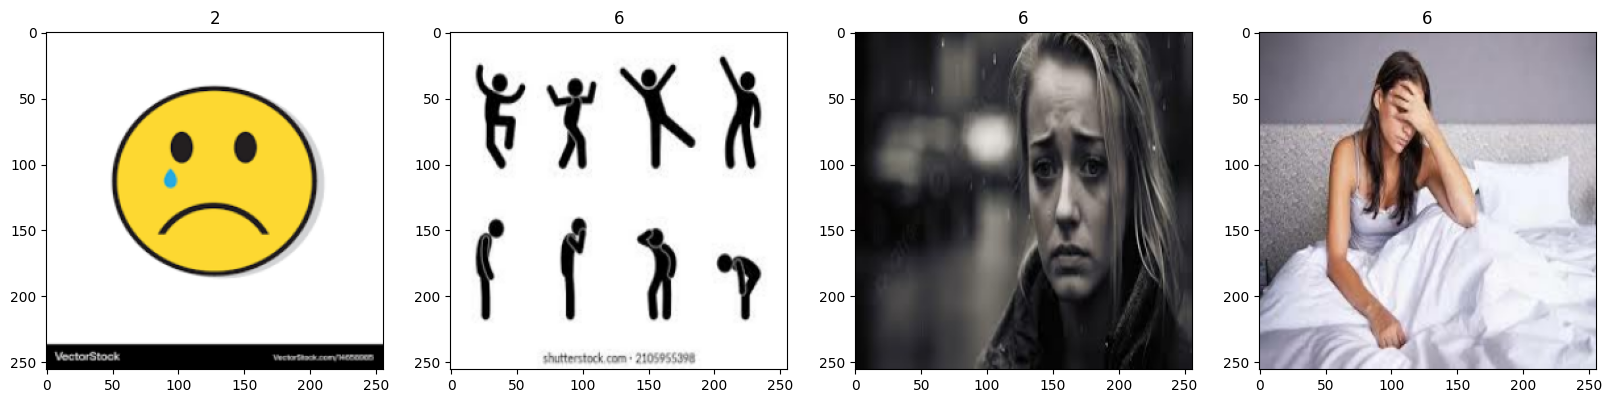

In [13]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# Scale data

In [14]:
data = data.map(lambda x, y: (x/255, y))

# Split data

In [15]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

train_data = data.take(train_size)
val_data = data.skip(train_size).take(val_size)
test_data = data.skip(train_size + val_size).take(test_size)

# Model

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [30]:
cnn_model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(256,256,3)),
    MaxPooling2D(),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(),
    Conv2D(16, (3,3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(7, activation='softmax')
])

In [32]:
cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [35]:
hist = cnn_model.fit(train_data, epochs=5, validation_data=val_data, class_weight=class_weights_dict, verbose=1)

Epoch 1/5
77/77 [==============================] - 19s 236ms/step - loss: 0.1277 - accuracy: 0.9667 - val_loss: 2.2455 - val_accuracy: 0.6065
Epoch 2/5
77/77 [==============================] - 20s 249ms/step - loss: 0.0923 - accuracy: 0.9748 - val_loss: 2.1825 - val_accuracy: 0.6065
Epoch 3/5
77/77 [==============================] - 20s 250ms/step - loss: 0.0814 - accuracy: 0.9785 - val_loss: 2.7237 - val_accuracy: 0.5923
Epoch 4/5
77/77 [==============================] - 18s 229ms/step - loss: 0.0691 - accuracy: 0.9830 - val_loss: 2.4456 - val_accuracy: 0.5781
Epoch 5/5
77/77 [==============================] - 18s 229ms/step - loss: 0.0486 - accuracy: 0.9870 - val_loss: 2.4966 - val_accuracy: 0.6179


Text(0.5, 1.0, 'Training and validation loss')

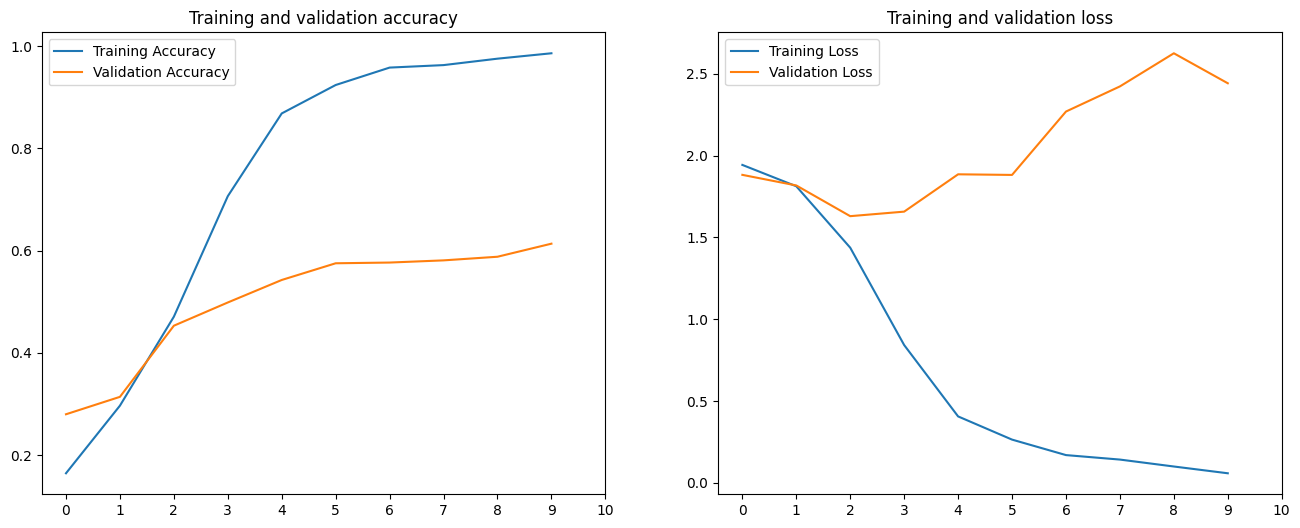

In [21]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = len(acc)

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.xticks(range(0, epochs+1, 1))
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xticks(range(0, epochs+1, 1))
plt.legend()
plt.title('Training and validation loss')

# Evaluate 

In [22]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [23]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

for batch in test_data.as_numpy_iterator(): 
    X, y = batch
    yhat = np.argmax(cnn_model.predict(X), axis=1)
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    accuracy.update_state(y, yhat)

1/1 [==============================] - 1s 648ms/step


In [24]:
print(precision.result(), recall.result(), accuracy.result())

tf.Tensor(0.91843975, shape=(), dtype=float32) tf.Tensor(0.91519433, shape=(), dtype=float32) tf.Tensor(0.17445482, shape=(), dtype=float32)


# Test

In [25]:
import cv2

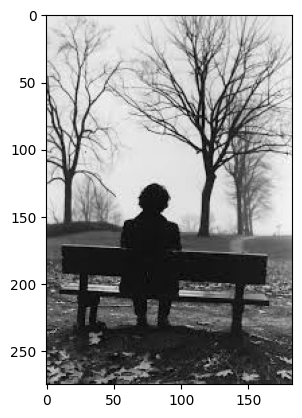

In [26]:
img = cv2.imread('test.jpg')
plt.imshow(img)
plt.show()

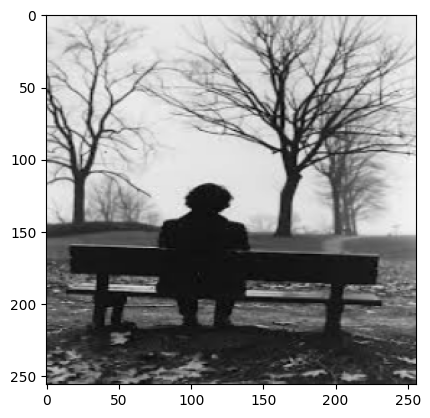

In [27]:
resize_im = tf.image.resize(img, (256,256))
plt.imshow(resize_im.numpy().astype(int))
plt.show()

In [28]:
yhat = np.argmax(cnn_model.predict(np.expand_dims(resize_im/255, 0)), axis=1)
print("Predict state img: ", class_names[yhat[0]])

1/1 [==============================] - 0s 32ms/step
Predict state img:  happy


In [29]:
from tensorflow.keras.models import load_model

cnn_model.save(os.path.join('models','states_classifier.keras'))

# Test saved model
model = load_model('models\\states_classifier.keras')

yhat = np.argmax(model.predict(np.expand_dims(resize_im/255, 0)), axis=1)
print("Predict state img: ", class_names[yhat[0]])

1/1 [==============================] - 0s 63ms/step
Predict state img:  happy
